In [1]:
import sys
print(sys.version)
print(sys.path)
sys.path.remove('/home/obin/catkin_ws/devel/lib/python2.7/dist-packages')
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]
['', '/home/obin/catkin_ws/devel/lib/python2.7/dist-packages', '/opt/ros/kinetic/lib/python2.7/dist-packages', '/usr/lib/python35.zip', '/usr/lib/python3.5', '/usr/lib/python3.5/plat-x86_64-linux-gnu', '/usr/lib/python3.5/lib-dynload', '/home/obin/.local/lib/python3.5/site-packages', '/usr/local/lib/python3.5/dist-packages', '/usr/lib/python3/dist-packages', '/home/obin/.local/lib/python3.5/site-packages/IPython/extensions', '/home/obin/.ipython']


# Data Process

In [2]:
#import pyrealsense2 as rs
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import joblib
#import scipy.misc
import tensorflow as tf
#from skimage.restoration import denoise_tv_chambolle
from tensorboardX import SummaryWriter
import copy

In [3]:
pp_path = '/home/obin/t2b_dataset/meta_data'
rg_path = '/home/obin/t2b_dataset/rgbd_data'
meta_list = np.sort([pp_path+'/'+x for x in os.listdir(pp_path)])
rgbd_list = np.sort([rg_path+'/'+x for x in os.listdir(rg_path)])
num_data = len(meta_list)
print('num of data : ', num_data)

num of data :  342


## depth image preprocess

In [5]:
#np.random.shuffle(data_list)
data_list

NameError: name 'data_list' is not defined

# black patch

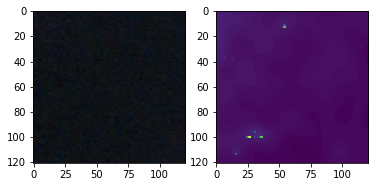

(242, 242, 4)

In [9]:
img = joblib.load('/home/obin/t2b_dataset/rgbd_data/0003/0003.dat.gz')
black_patch = np.uint8(img[10:131,10:131,:]*255)
#black_patch[:,:,0:3] = cv2.cvtColor(black_patch[:,:,0:3],cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(black_patch[:,:,0:3])
plt.subplot(122)
plt.imshow(black_patch[:,:,3])
plt.show()
black_patch = np.hstack([black_patch,black_patch])
black_patch = np.vstack([black_patch,black_patch])
black_patch.shape

In [7]:
img

array([[[0.03137255, 0.05098039, 0.10980392, 0.08006452],
        [0.03137255, 0.05098039, 0.12941176, 0.08027312],
        [0.03921569, 0.05490196, 0.12941176, 0.08066981],
        ...,
        [0.07058824, 0.12156863, 0.14117647, 0.05320223],
        [0.0627451 , 0.11372549, 0.13333333, 0.05340357],
        [0.07058824, 0.11372549, 0.14901961, 0.05350486]],

       [[0.02352941, 0.05490196, 0.09803922, 0.08050989],
        [0.03137255, 0.0627451 , 0.13333333, 0.08076669],
        [0.04313725, 0.05882353, 0.1254902 , 0.08129766],
        ...,
        [0.07058824, 0.12156863, 0.14901961, 0.05317298],
        [0.07058824, 0.1254902 , 0.14901961, 0.05337212],
        [0.08627451, 0.12156863, 0.16470588, 0.05347217]],

       [[0.01960784, 0.04705882, 0.08627451, 0.08153647],
        [0.02745098, 0.05490196, 0.10980392, 0.08185449],
        [0.03529412, 0.05098039, 0.11372549, 0.08247384],
        ...,
        [0.05098039, 0.09411765, 0.12941176, 0.05311329],
        [0.06666667, 0.109803

In [6]:
safe_distance = 3
max_move1 = 40
max_move2 = 40

# functions

In [26]:
def overlap(r1,r2):
    hoverlaps = not((r1[0] > r2[1]) or (r1[1] < r2[0]))
    voverlaps = not((r1[3] < r2[2]) or (r1[2] > r2[3]))
    
#     if r1 is r2 :
#         print('same object')
#         return False
    return hoverlaps and voverlaps  

def draw_circle(event,x,y,flags,param):
    global mouseX,mouseY
    if event == cv2.EVENT_LBUTTONDBLCLK:
        #cv2.circle(i,(x,y),10000,(255,0,0),-1)
        mouseX,mouseY = x,y
        #print('point x:{0}, y:{1}'.format(mouseX,mouseY))
def overlap_with_others(obj, object_list):
    overlap_with_others = False
    for other_idx, other_obj in enumerate(object_list) :
        if overlap(other_obj, obj):
            new_obj_min_x = min(other_obj[0],obj[0])
            new_obj_max_x = max(other_obj[1],obj[1])
            new_obj_min_y = min(other_obj[2],obj[2])
            new_obj_max_y = max(other_obj[3],obj[3])
            object_list[other_idx] = [new_obj_min_x, new_obj_max_x, new_obj_min_y, new_obj_max_y]
            overlap_with_others = True
    return overlap_with_others, object_list
    
def extract_objects(img,safe_distance=5):
    img = np.uint8(img*255)
    kernel = np.ones((3,3),np.float32)/(3*2)
    img = cv2.filter2D(img,-1,kernel)
    for tx in range(256):
        for ty in range(256):
            color = np.array(img[tx,ty,:],dtype=np.int64)
            if (abs(color[0]-color[1]) < 30) and (abs(color[1]-color[2]) < 30): 
                img[tx,ty,:] = [30,30,30]

    imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray,50,255,0)
    contours, hierachy = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    hulls = []
    for c in contours :
        if np.array(c).shape[0] <= 1 : continue
        hulls.append(cv2.convexHull(c))
    
    image = cv2.drawContours(img, hulls, -1, (0,255,0), 3)
    object_list = []
    for h in hulls :
        x = np.array(h).squeeze()[:,0]
        y = np.array(h).squeeze()[:,1]
        (topx, topy) = (np.min(x), np.min(y))
        (bottomx, bottomy) = (np.max(x), np.max(y))
        #out = np.zeros_like(img)
        dx = bottomx - topx
        dy = bottomy - topy


        out = img[topy:bottomy+1,topx:bottomx+1:]
        mean = np.mean(out, axis=(0,1))

        if dx*dy <= 800 : continue
        if (abs(mean[0] - mean[1]) < 20)and(abs(mean[1] - mean[2]) < 20) : continue
            
        obj = [topx-safe_distance,bottomx+safe_distance,
               topy-safe_distance,bottomy+safe_distance]
        object_list.append(np.clip(obj,0,255))
#         overlap, new_list = overlap_with_others(obj,object_list)
#         if not overlap :
#             #object_list = new_list
#             object_list.append(np.clip(obj,0,255))
#         else :
#             object_list = new_list
        
        
    return hulls, object_list
    

def where_is(pose,objs):
    for idx, obj in enumerate(objs):
        x_ok = obj[0] < pose[0] and obj[1] > pose[0] 
        y_ok = obj[2] < pose[1] and obj[3] > pose[1]
        
        if x_ok and y_ok : return idx
    return -1
            

def move_object(ids,move,object_list,img,black_patch):
    #print('move ', move)
    ob = object_list[ids]
    
    moved_ob = np.array(ob-move,dtype=np.int64)
    if not(all(moved_ob<255) and all(moved_ob>0)) : 
        return False, None, None
    #   print('moved', moved_ob)
    safe_flag = False
    for other_ob in object_list :
        if overlap(moved_ob,other_ob) and any(other_ob != ob) :
            safe_flag=False
            return False, None, None
        safe_flag = True
    object_img = copy.deepcopy(img[ob[2]:ob[3]+1,ob[0]:ob[1]+1,:])

    if safe_flag : 
        dy = ob[3] - ob[2] + 1
        dx = ob[1] - ob[0] + 1
        img[ob[2]:ob[3]+1,ob[0]:ob[1]+1,:] = black_patch[0:dy,0:dx,:]
        img[moved_ob[2]:moved_ob[3]+1, moved_ob[0]:moved_ob[1]+1, :] = object_img
        object_list[ids] = moved_ob
        return True, img, object_list

    return False, None, None



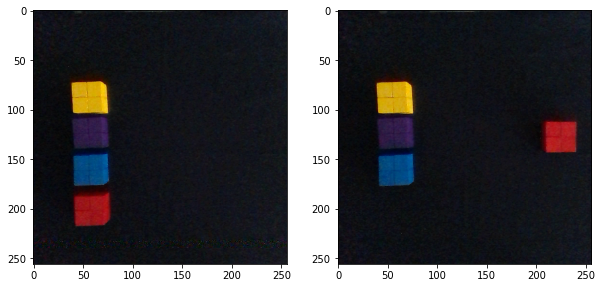

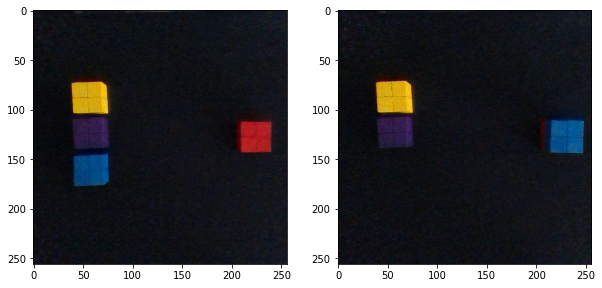

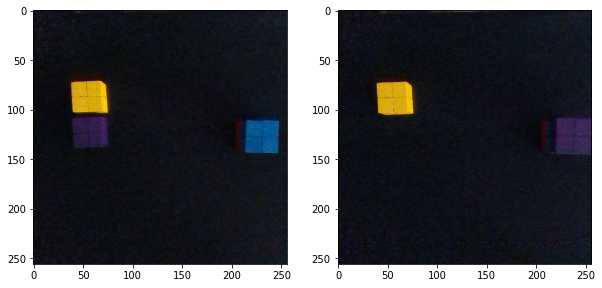

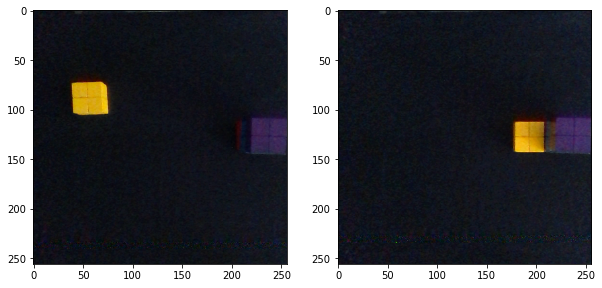

In [72]:
scene_idx = 38

curr_list = np.sort([meta_list[scene_idx]+'/'+x for x in os.listdir(meta_list[scene_idx])])
curr_rg_list = np.sort([rgbd_list[scene_idx]+'/'+x for x in os.listdir(rgbd_list[scene_idx])])
for i in range(len(curr_rg_list)-1):
    curr_data = joblib.load(curr_list[i])
    s_img = joblib.load(curr_rg_list[i])[:,:,0:3]
    s_img_depth = joblib.load(curr_rg_list[i])[:,:,3]

    e_img = joblib.load(curr_rg_list[i+1])[:,:,0:3]
    e_img_depth = joblib.load(curr_rg_list[i+1])[:,:,3]
    
    fig = plt.figure(figsize=(10,10))
    s_ax = fig.add_subplot(121)
    s_ax.imshow(s_img)
    e_ax = fig.add_subplot(122)
    e_ax.imshow(e_img) 
    
    plt.show()



# block segmentation

In [10]:
resume = 80
for scene_idx in range(resume, len(rgbd_list-1)):
    curr_list = np.sort([meta_list[scene_idx]+'/'+x for x in os.listdir(meta_list[scene_idx])])
    curr_rg_list = np.sort([rgbd_list[scene_idx]+'/'+x for x in os.listdir(rgbd_list[scene_idx])])
    for i in range(len(curr_list)-1):
        curr_data = joblib.load(curr_list[i])
        s_img = joblib.load(curr_rg_list[i])[:,:,0:3]
        s_img_depth = joblib.load(curr_rg_list[i])[:,:,3]

        e_img = joblib.load(curr_rg_list[i+1])[:,:,0:3]
        e_img_depth = joblib.load(curr_rg_list[i+1])[:,:,3]
#         s_img = curr_data['start_image'][:,:,0:3]
#         s_img_depth = curr_data['end_image'][:,:,3]
#         e_img = curr_data['end_image'][:,:,0:3]
#         e_img_depth = curr_data['end_image'][:,:,3]
        
        
        
        s_hulls,s_objs = extract_objects(s_img)
        e_hulls,e_objs = extract_objects(e_img)


        data_dict = dict()
        pair_idx = []
        no_care_idx = []

        paired_e_idx = []
        for s_idx, s_ob in enumerate(s_objs) :
            s_counter = np.array([np.mean(s_ob[0:2]),np.mean(s_ob[2:4])])
            for tr in range(4):
                e_idx = where_is(s_counter,e_objs)
                if e_idx != -1 :
                    sd = int(min(s_ob[1] - s_ob[0],s_ob[3] - s_ob[2])/4.0)
                    a = [sd,sd]
                    iz = int(tr/2.0)
                    a[iz] = np.power(-1, tr) * sd 
                    e_idx = where_is(s_counter-a,e_objs)

            if e_idx != -1 :
                e_ob = e_objs[e_idx]
                pair_idx.append([s_idx,e_idx])
                paired_e_idx.append(e_idx)

                randcolor = (np.random.randint(0,100,size=3) + np.array([10,10,150]))/255.0
            else :
                no_care_idx.append([0,s_idx])

        for k in range(len(e_objs)):
            if k in paired_e_idx : continue
            else : 
                e_ob = e_objs[k]
                no_care_idx.append([1,k])

        if len(pair_idx) == 0 :
            print('-'*50 + 'check scene {0}, pic {1}'.format(scene_idx, i))

        data_dict['start_image'] = np.concatenate([s_img,s_img_depth.reshape(256,256,1)],axis=2)
        data_dict['end_image'] = np.concatenate([e_img,e_img_depth.reshape(256,256,1)],axis=2)
        data_dict['pair_idx'] = pair_idx
        data_dict['no_care_idx'] = no_care_idx
        data_dict['start_objects'] = s_objs
        data_dict['end_objects'] = e_objs
        data_dict['start_pos'] = curr_data['start_pos']
        data_dict['end_pos'] = curr_data['end_pos']

        if not os.path.exists('/home/pre_generated/%04d'%scene_idx):
            os.mkdir('/home/pre_generated/%04d'%scene_idx)

        data_name = os.path.join('/home/obin/pre_generated/%04d'%scene_idx, '%04d.dat.gz'%i)
        joblib.dump(data_dict,data_name)
        print(data_name)






NameError: name 'spd_list' is not defined

In [ ]:
curr_data.keys()


In [ ]:
meta_list

In [ ]:
s_img_depth.shape

In [ ]:
plt.imshow(s_img)
plt.show()

In [19]:
data_path = '/home/obin/t2b_dataset/pre_generated'
spd_list = np.sort([data_path+'/'+x for x in os.listdir(os.path.join(data_path,''))])
num_data = len(spd_list)
spd_list

array(['/home/obin/t2b_dataset/pre_generated/0000',
       '/home/obin/t2b_dataset/pre_generated/0001',
       '/home/obin/t2b_dataset/pre_generated/0002',
       '/home/obin/t2b_dataset/pre_generated/0003',
       '/home/obin/t2b_dataset/pre_generated/0004',
       '/home/obin/t2b_dataset/pre_generated/0005',
       '/home/obin/t2b_dataset/pre_generated/0006',
       '/home/obin/t2b_dataset/pre_generated/0007',
       '/home/obin/t2b_dataset/pre_generated/0008',
       '/home/obin/t2b_dataset/pre_generated/0009',
       '/home/obin/t2b_dataset/pre_generated/0010',
       '/home/obin/t2b_dataset/pre_generated/0011',
       '/home/obin/t2b_dataset/pre_generated/0012',
       '/home/obin/t2b_dataset/pre_generated/0013',
       '/home/obin/t2b_dataset/pre_generated/0014',
       '/home/obin/t2b_dataset/pre_generated/0015',
       '/home/obin/t2b_dataset/pre_generated/0016',
       '/home/obin/t2b_dataset/pre_generated/0017',
       '/home/obin/t2b_dataset/pre_generated/0018',
       '/hom

# check

In [14]:
fix_list = []

******************SCENE 1******************
-------------step 0-------------


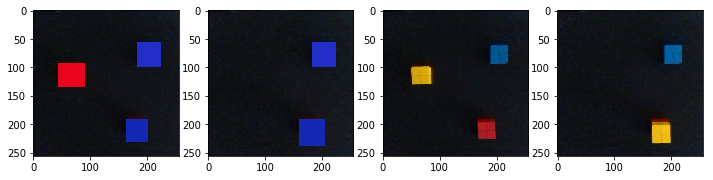

-------------step 1-------------


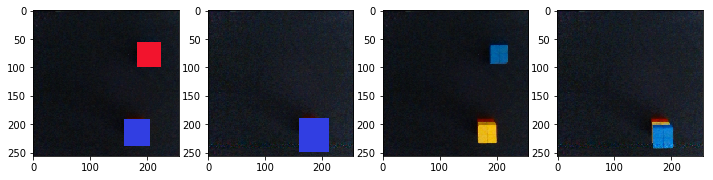

is it okay?stop


In [28]:
resume = 1
for scene_idx in range(resume, resume+1):
    curr_list = np.sort([spd_list[scene_idx]+'/'+x for x in os.listdir(spd_list[scene_idx])])
    num_data = len(curr_list)
    print('******************SCENE %d******************'%scene_idx)
    for i in range(num_data):
        curr_data = joblib.load(curr_list[i])
        print('-------------step {0}-------------'.format(i))
        s_img = copy.deepcopy(curr_data['start_image'])
        e_img = copy.deepcopy(curr_data['end_image'])
        pair_idx = curr_data['pair_idx']
        no_care_idx = curr_data['no_care_idx']
        s_objs = curr_data['start_objects']
        e_objs = curr_data['end_objects']

        fig = plt.figure(figsize=(12,12))
        s_ax = fig.add_subplot(141)

        s_ax.imshow(s_img[:,:,0:3])
        e_ax = fig.add_subplot(142)
        e_ax.imshow(e_img[:,:,0:3])    
        s_ax2 = fig.add_subplot(143)
        s_ax2.imshow(s_img[:,:,0:3])
        e_ax2 = fig.add_subplot(144)
        e_ax2.imshow(e_img[:,:,0:3])

        for pair in pair_idx:
            s_ob = s_objs[pair[0]]
            e_ob = e_objs[pair[1]]

            randcolor = (np.random.randint(0,100,size=3) + np.array([10,10,150]))/255.0
            rect = patches.Rectangle((s_ob[0],s_ob[2]),s_ob[1]-s_ob[0],s_ob[3]-s_ob[2],
                                     linewidth=0.00,edgecolor=randcolor,facecolor=randcolor)
            s_ax.add_patch(rect)

            rect = patches.Rectangle((e_ob[0],e_ob[2]),e_ob[1]-e_ob[0],e_ob[3]-e_ob[2],
                                     linewidth=0.0,edgecolor=randcolor,facecolor=randcolor)
            e_ax.add_patch(rect)

        for idx in no_care_idx :
            if idx[0] == 0 :
                s_ob = s_objs[idx[1]]
                randcolor = (np.random.randint(0,50,size=3) + np.array([200,0,0]))/255.0
                rect = patches.Rectangle((s_ob[0],s_ob[2]),s_ob[1]-s_ob[0],s_ob[3]-s_ob[2],
                                         linewidth=0.0,edgecolor=randcolor,facecolor=randcolor)
                s_ax.add_patch(rect)

            elif idx[0] == 1 :
                e_ob = e_objs[idx[1]]
                randcolor = (np.random.randint(0,50,size=3) + np.array([200,0,0]))/255.0
                rect = patches.Rectangle((e_ob[0],e_ob[2]),e_ob[1]-e_ob[0],e_ob[3]-e_ob[2],
                                         linewidth=0.00,edgecolor=randcolor,facecolor=randcolor)
                e_ax.add_patch(rect)

        plt.show()

    
    k = input('is it okay?')
    if k == 'yes' : 
        print('\n\n\n')
        continue
    elif k == 'stop' : break
    else : 
        while(True):
            fixes =[]
            while(True):
                fix = input('which step do you want to fix?')
                if fix == 'q' : break
                else : fixes.append(int(fix))
                    
            for fix in fixes : 
                curr_data = joblib.load(curr_list[fix])
                print('-------------scene {0}-------------'.format(fix))
                s_img = copy.deepcopy(curr_data['start_image'])
                e_img = copy.deepcopy(curr_data['end_image'])
                pair_idx = curr_data['pair_idx']
                no_care_idx = curr_data['no_care_idx']
                s_objs = curr_data['start_objects']
                e_objs = curr_data['end_objects']

                fig = plt.figure(figsize=(12,12))
                s_ax = fig.add_subplot(141)

                s_ax.imshow(s_img[:,:,0:3])
                e_ax = fig.add_subplot(142)
                e_ax.imshow(e_img[:,:,0:3])    
                s_ax2 = fig.add_subplot(143)
                s_ax2.imshow(s_img[:,:,0:3])
                e_ax2 = fig.add_subplot(144)
                e_ax2.imshow(e_img[:,:,0:3])

                for pair in pair_idx:
                    s_ob = s_objs[pair[0]]
                    e_ob = e_objs[pair[1]]

                    randcolor = (np.random.randint(0,100,size=3) + np.array([10,10,150]))/255.0
                    rect = patches.Rectangle((s_ob[0],s_ob[2]),s_ob[1]-s_ob[0],s_ob[3]-s_ob[2],
                                             linewidth=3,edgecolor=randcolor,facecolor=randcolor)
                    s_ax.add_patch(rect)

                    rect = patches.Rectangle((e_ob[0],e_ob[2]),e_ob[1]-e_ob[0],e_ob[3]-e_ob[2],
                                             linewidth=3,edgecolor=randcolor,facecolor=randcolor)
                    e_ax.add_patch(rect)

                for idx in no_care_idx :
                    if idx[0] == 0 :
                        s_ob = s_objs[idx[1]]
                        randcolor = (np.random.randint(0,50,size=3) + np.array([200,0,0]))/255.0
                        rect = patches.Rectangle((s_ob[0],s_ob[2]),s_ob[1]-s_ob[0],s_ob[3]-s_ob[2],
                                                 linewidth=3,edgecolor=randcolor,facecolor=randcolor)
                        s_ax.add_patch(rect)

                    elif idx[0] == 1 :
                        e_ob = e_objs[idx[1]]
                        randcolor = (np.random.randint(0,50,size=3) + np.array([200,0,0]))/255.0
                        rect = patches.Rectangle((e_ob[0],e_ob[2]),e_ob[1]-e_ob[0],e_ob[3]-e_ob[2],
                                                 linewidth=0.1,edgecolor=randcolor,facecolor=randcolor)
                        e_ax.add_patch(rect)
                        
                plt.show()


            message = input('anything else?')
            for fix in fixes :
                fix_list.append([scene_idx, fix, message])
            if message == 'q': break
            elif message == 'a': continue






# random generation

In [70]:
resume = 1
howmanytry = 100
max_gen = 10
safe_distance = 3
max_move1 = 40
max_move2 = 40

for scene_idx in range(resume,resume+1):

    curr_list = np.sort([spd_list[scene_idx]+'/'+x for x in os.listdir(spd_list[scene_idx])])
    num_command = len(curr_list)
    save_path = spd_list[scene_idx].replace('pre_generated','generated')
    if not os.path.exists(save_path): os.mkdir(save_path)
    gen_num = 0
    for j in range(howmanytry):
        currently_ok = True
        s_imgs = []
        e_imgs = []

        for i in range(num_command):
            curr_data = joblib.load(curr_list[i])
            print('-------------scene {0}, step {1} ,{2}th generation-------------'.format(scene_idx,i,j))
            s_img = np.uint8(copy.deepcopy(curr_data['start_image'])*255)
            e_img = np.uint8(copy.deepcopy(curr_data['end_image'])*255)
            pair_idx = curr_data['pair_idx']
            no_care_idx = curr_data['no_care_idx']
            s_objs = curr_data['start_objects']
            e_objs = curr_data['end_objects']
            start_pos = curr_data['start_pos']
            end_pos = curr_data['end_pos']
            s_moves = []
            e_moves = []
            moving_object_idx = where_is(start_pos, s_objs)
            moved_object_idx = where_is(end_pos, e_objs)
            print('moving object s-{0} e-{1}'.format(moving_object_idx, moved_object_idx))

            for pair in pair_idx :
                for tr in range(6):
                    #print(i)
                    if i == 0 :
                        move = np.ones(4)
                        move[0:2] *= np.random.randint(-max_move1,max_move1+1)
                        move[2:4] *= np.random.randint(-max_move1,max_move1+1)
                    else :
                        for s, prev in enumerate(prev_moves):
                            if prev[0] == pair[0] : 
                                move = prev[1]
                                #print('found it!')
                                currently_ok = True
                                break
                            else:
                                move = []
                                print('notfound')
                                currently_ok = False
                    if len(move) == 0: 
                        print('Not found')
                        currently_ok = False
                        break
                            
                    s, s_moved_img, s_moved_objs = move_object(pair[0],move,s_objs,s_img,black_patch)
                    e, e_moved_img, e_moved_objs = move_object(pair[1],move,e_objs,e_img,black_patch)
                    if s and e : 
                        s_img = s_moved_img
                        e_img = e_moved_img
                        s_objs = s_moved_objs
                        e_objs = e_moved_objs
                        s_moves.append([pair[0],move])
                        e_moves.append([pair[1],move])
                        print('suc ',move)
                        break
                    elif not (s and e) and i != 0 :
                        print('fail')
                        currently_ok = False
                        

            for idx in no_care_idx :
                for tr in range(6):
                    if i == 0 :
                        move = np.ones(4)
                        move[0:2] *= np.random.randint(-max_move1,max_move1+1)
                        move[2:4] *= np.random.randint(-max_move1,max_move1+1)
                    elif idx[0] == 0 :
                        for s, prev in enumerate(prev_moves):
                            if prev[0] == idx[1] : 
                                move = prev[1]
                                print('found_it!')
                                currently_ok = True
                                break
                            move = []
                            currently_ok = False
                    if len(move) == 0: break
                    print(currently_ok)
                    if idx[0] == 0 : 
                        result, s_moved_img, s_moved_objs = move_object(idx[1],move,s_objs,s_img,black_patch)
                        if result :
                            s_img = s_moved_img
                            s_objs = s_moved_objs
                            s_moves.append([idx[1],move])
                            break
                        else :
                            print('fail')
                            currently_ok = False
                    elif idx[0] == 1:
                        result, e_moved_img, e_moved_objs = move_object(idx[1],move,e_objs,e_img,black_patch)
                        if result:
                            e_img = e_moved_img
                            e_objs = e_moved_objs
                            e_moves.append([idx[1],move])
                            break
                        else :
                            print('fail')
                            currently_ok = False

            prev_moves = copy.deepcopy(e_moves)
            start_pos = np.array(start_pos,dtype=np.int64)
            end_pos = np.array(end_pos,dtype=np.int64)
            
            s_img[start_pos[1]-2:start_pos[1]+2,start_pos[0]-2:start_pos[0]+2,0:3] = [255,255,255]
            s_img[end_pos[1]-2:end_pos[1]+2,end_pos[0]-2:end_pos[0]+2,0:3] = [255,255,255]
            
            for s, prev in enumerate(s_moves):
                if prev[0] == moving_object_idx : 
                    moving_object_move = prev[1]
                    print('start_post moved {0}, {1}'.format(moving_object_move[0],moving_object_move[2]))
                    start_pos = np.array(start_pos - [moving_object_move[0],moving_object_move[2]],dtype=np.int64)
                    break
            
            for s, prev in enumerate(e_moves):
                if prev[0] == moved_object_idx : 
                    moved_object_move = prev[1]
                    print('end_post moved {0}, {1}'.format(moved_object_move[0],moved_object_move[2]))
                    end_pos = np.array(end_pos - [moved_object_move[0],moved_object_move[2]],dtype=np.int64)
                    break

            s_img[start_pos[1]-2:start_pos[1]+2,start_pos[0]-2:start_pos[0]+2,0:3] = [255,0,255]
            s_img[end_pos[1]-2:end_pos[1]+2,end_pos[0]-2:end_pos[0]+2,0:3] = [51,204,255]
            
            if currently_ok : 
                s_imgs.append(s_img)
                e_imgs.append(e_img)
            else :
                print('FAILED')
                plt.imshow(s_img[:,:,0:3])
                plt.imshow(e_img[:,:,0:3])
                plt.show()
                break

        if currently_ok : 
            print('gen_num %d'%gen_num)
            for i in range(num_command) :
                plt.imsave(os.path.join(save_path,'%04d.png'%(gen_num*100+i)),s_imgs[i][:,:,0:3])
                if i == num_command - 1 :
                    plt.imsave(os.path.join(save_path,'%04d.png'%(gen_num*100+i+1)),e_imgs[i][:,:,0:3])
            gen_num += 1
            

        if gen_num == max_gen :
            break
            
        print('\n\n\n')
#             kernel = np.ones((3,3),np.float32)/(3*2)
#             s_img = cv2.filter2D(s_img,-1,kernel)
#             for tx in range(256):
#                 for ty in range(256):
#                     color = np.array(s_img[tx,ty,:],dtype=np.int64)
#                     if (abs(color[0]-color[1]) < 30) and (abs(color[1]-color[2]) < 30): 
#                         s_img[tx,ty,:] = [30,30,30]

#             e_img = cv2.filter2D(e_img,-1,kernel)
#             for tx in range(256):
#                 for ty in range(256):
#                     color = np.array(e_img[tx,ty,:],dtype=np.int64)
#                     if (abs(color[0]-color[1]) < 30) and (abs(color[1]-color[2]) < 30): 
#                         e_img[tx,ty,:] = [30,30,30]

#             stacked_img = np.hstack([s_img,e_img])
#             plt.imsave(os.path.join(save_path,'img/%02th/%04.png'%(j,i),stacked_img)
    







    

-------------scene 1, step 0 ,0th generation-------------
moving object s-1 e-0
suc  [30. 30.  6.  6.]
suc  [12. 12. -5. -5.]
True
start_post moved 10.0, 8.0
end_post moved 30.0, 6.0
-------------scene 1, step 1 ,0th generation-------------
moving object s-1 e-0
suc  [30. 30.  6.  6.]
found_it!
True
start_post moved 12.0, -5.0
end_post moved 30.0, 6.0
gen_num 0




-------------scene 1, step 0 ,1th generation-------------
moving object s-1 e-0
suc  [-32. -32.  11.  11.]
suc  [-24. -24.  32.  32.]
True
start_post moved 31.0, -7.0
end_post moved -32.0, 11.0
-------------scene 1, step 1 ,1th generation-------------
moving object s-1 e-0
suc  [-32. -32.  11.  11.]
found_it!
True
start_post moved -24.0, 32.0
end_post moved -32.0, 11.0
gen_num 1




-------------scene 1, step 0 ,2th generation-------------
moving object s-1 e-0
suc  [-5. -5. 26. 26.]
suc  [ 12.  12. -36. -36.]
True
start_post moved -18.0, 25.0
end_post moved -5.0, 26.0
-------------scene 1, step 1 ,2th generation------------

In [56]:
currently_ok

False

In [55]:
s_moves

[[0, array([-2., -2., 40., 40.])], [1, array([ 9.,  9., 11., 11.])]]

In [40]:
moved_object_idx

0

In [47]:
curr_data = joblib.load(curr_list[1])
print('-------------scene {0}, step {1} ,{2}th generation-------------'.format(scene_idx,i,j))
s_img = np.uint8(copy.deepcopy(curr_data['start_image'])*255)
e_img = np.uint8(copy.deepcopy(curr_data['end_image'])*255)
pair_idx = curr_data['pair_idx']
no_care_idx = curr_data['no_care_idx']
s_objs = curr_data['start_objects']
e_objs = curr_data['end_objects']
start_pos = curr_data['start_pos']
end_pos = curr_data['end_pos']
s_moves = []
e_moves = []
moving_object_idx = where_is(start_pos, s_objs)
moved_object_idx = where_is(end_pos, e_objs)
print('moving object s-{0} e-{1}'.format(moving_object_idx, moved_object_idx))


-------------scene 1, step 1 ,0th generation-------------
moving object s-1 e-0


In [48]:
pair_idx

[[0, 0]]

# CHECK GENRATED

In [5]:
data_path = '/home/obin/t2b_dataset/generated'
generated_list = np.sort([data_path+'/'+x for x in os.listdir(os.path.join(data_path,''))])
num_data = len(generated_list)
watch_list = []


In [ ]:
resume = 39
for scene_idx in range(resume, num_data):
    curr_list = np.sort([generated_list[scene_idx]+'/'+x for x in os.listdir(generated_list[scene_idx])])
    num_command = len(curr_list)
    if num_command == 0 :
        watch_list.append(scene_idx)
        continue
    winname = '%04d'%(scene_idx)
    cv2.namedWindow(winname)
    cv2.moveWindow(winname,350,500)
    for i in range(len(curr_list)) :
        img = cv2.imread(curr_list[i])
        cv2.imshow(winname,img)           
        key = cv2.waitKey()
        if key & 0xFF == ord('s'):
            watch_list.append(scene_idx)
        elif key & 0xFF == ord('q'):
            break
    if key & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break

    

In [7]:
watch_list

[6, 7, 8, 18, 19, 20, 24, 27, 28, 31, 32, 37, 37, 38, 39]

In [16]:
fix_list.extend([[7, '0', 'q'],
         [16, '2', 'q'],
         [18, '4', 'q'],
         [19, '2', 'q'],
         [22, '3', 'q'],
         [24, '3', '4'],
         [24, '4', 'q'],
         [25, '3', 'no'],
         [30, '2', '3'],
         [30, '3', 'q'],
         [31, '2', '2'],
         [31, '3', 'q'],
         [32, '2', 'yes'],
         [32, '3', 'no']])


[[82, '0', 'we need to fix all of it'],
 [82, '1', '2'],
 [82, '2', '3'],
 [82, '3', '4'],
 [82, '4', '5'],
 [82, '5', 'q'],
 [85, '4', 'q'],
 [86, '1', '2'],
 [86, '2', 'q'],
 [87, '4', '4'],
 [87, '5', 'q'],
 [88, '1', '2'],
 [88, '3', '4'],
 [88, '4', '5'],
 [88, '5', 'q'],
 [90, '5', 'q']]

In [18]:
fix_list

[[82, '0', 'we need to fix all of it'],
 [82, '1', '2'],
 [82, '2', '3'],
 [82, '3', '4'],
 [82, '4', '5'],
 [82, '5', 'q'],
 [85, '4', 'q'],
 [86, '1', '2'],
 [86, '2', 'q'],
 [87, '4', '4'],
 [87, '5', 'q'],
 [88, '1', '2'],
 [88, '3', '4'],
 [88, '4', '5'],
 [88, '5', 'q'],
 [90, '5', 'q'],
 [38, '3', 'q'],
 [39, '3', 'q'],
 [40, '0', 'q'],
 [41, '2', 'no'],
 [43, '1', '2'],
 [43, '2', 'q'],
 [50, '0', 'yes'],
 [50, '2', 'yes'],
 [50, '3', 'q'],
 [53, '1', '3'],
 [53, '3', 'q'],
 [55, '0', '1'],
 [55, '1', '2'],
 [55, '2', '4'],
 [55, '4', 'q'],
 [56, '1', '2'],
 [56, '2', 'q'],
 [57, '2', '3'],
 [57, '3', '4'],
 [57, '4', 'no'],
 [59, '0', '1'],
 [59, '1', 'q'],
 [60, '0', "we'd better not to change this scene"],
 [67, '3', '4'],
 [67, '4', 'q'],
 [68, '0', '1'],
 [68, '1', '2'],
 [68, '2', '4'],
 [68, '4', 'q'],
 [72, '2', '3'],
 [72, '3', 'q'],
 [74, '5', 'no'],
 [76, '4', '5'],
 [76, '5', 'q'],
 [77, '0', '1'],
 [77, '1', '2'],
 [77, '2', '3'],
 [77, '3', '4'],
 [7, '0', 'q'],
 

In [20]:
fix_list = joblib.load('/home/obin/t2b_dataset/fix_list.dat.gz')
fix_list

[[82, '0', 'we need to fix all of it'],
 [82, '1', '2'],
 [82, '2', '3'],
 [82, '3', '4'],
 [82, '4', '5'],
 [82, '5', 'q'],
 [85, '4', 'q'],
 [86, '1', '2'],
 [86, '2', 'q'],
 [87, '4', '4'],
 [87, '5', 'q'],
 [88, '1', '2'],
 [88, '3', '4'],
 [88, '4', '5'],
 [88, '5', 'q'],
 [90, '5', 'q'],
 [38, '3', 'q'],
 [39, '3', 'q'],
 [40, '0', 'q'],
 [41, '2', 'no'],
 [43, '1', '2'],
 [43, '2', 'q'],
 [50, '0', 'yes'],
 [50, '2', 'yes'],
 [50, '3', 'q'],
 [53, '1', '3'],
 [53, '3', 'q'],
 [55, '0', '1'],
 [55, '1', '2'],
 [55, '2', '4'],
 [55, '4', 'q'],
 [56, '1', '2'],
 [56, '2', 'q'],
 [57, '2', '3'],
 [57, '3', '4'],
 [57, '4', 'no'],
 [59, '0', '1'],
 [59, '1', 'q'],
 [60, '0', "we'd better not to change this scene"],
 [67, '3', '4'],
 [67, '4', 'q'],
 [68, '0', '1'],
 [68, '1', '2'],
 [68, '2', '4'],
 [68, '4', 'q'],
 [72, '2', '3'],
 [72, '3', 'q'],
 [74, '5', 'no'],
 [76, '4', '5'],
 [76, '5', 'q'],
 [77, '0', '1'],
 [77, '1', '2'],
 [77, '2', '3'],
 [77, '3', '4'],
 [7, '0', 'q'],
 

In [19]:
joblib.dump(watch_list,'/home/obin/t2b_dataset/watch_list.dat.gz')

['/home/obin/t2b_dataset/watch_list.dat.gz']

In [26]:
joblib.dump(fix_list,'/home/obin/t2b_dataset/fix_list.dat.gz')

['/home/obin/t2b_dataset/fix_list.dat.gz']

In [27]:
watch_list

[6,
 7,
 8,
 18,
 19,
 20,
 24,
 27,
 28,
 31,
 32,
 37,
 37,
 38,
 39,
 41,
 42,
 43,
 47,
 47,
 47,
 48,
 50,
 50,
 53,
 55,
 59,
 59,
 60,
 65,
 67,
 68,
 70,
 72,
 73,
 74,
 76,
 77,
 78,
 79,
 80,
 82,
 83,
 84,
 84,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 95,
 96,
 100,
 101,
 106,
 110,
 111,
 113,
 114,
 118,
 120,
 121,
 124,
 132,
 133,
 135,
 137,
 139,
 142,
 146,
 149,
 150,
 154,
 155,
 156,
 159,
 162,
 165,
 166,
 167,
 168,
 169]

In [26]:
for element in fix_list:
    if element[0] == 2380:
        print("True")

In [32]:
num_normal = 0
for i in range(171):
    isin = False
    for element in fix_list:
        if element[0] == i:
            isin = True
            break
    if isin == False and not(i in watch_list) :
        print(i)
        num_normal+=1
        

0
1
2
3
4
5
9
10
11
12
13
14
15
17
21
23
26
29
33
34
35
36
44
45
46
49
51
52
54
58
61
62
63
64
66
69
71
75
81
93
94
97
98
99
102
103
104
105
107
109
112
115
116
117
119
122
123
125
127
128
129
130
131
134
136
140
141
143
144
145
147
148
151
152
153
157
160
161
163
170


In [33]:
num_normal

80